# ============================================================
# PhysioNet - Digitization of ECG Images
# Strong Grandmaster-style baseline (PyTorch + Implicit Decoder)
#
# Key idea:
#   - Encode ECG image -> latent vector (CNN encoder)
#   - Decode signal via implicit neural representation:
#       f(latent, t_norm) -> value_mV
#   - Works with variable fs / variable output lengths.
#
# Need to adjust (dataset-dependent):
#   - How training images map to leads.
#   - If train images are full 12-lead sheets, the optional cropper
#     below will attempt a simple 3x4 split. You can refine it.
#
# Notebook requirements: Internet OFF, <= 9h
# ============================================================


In [1]:
import os
import gc
import math
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image

# ---------- Repro ----------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  # speed
seed_everything(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Paths ----------
ROOT = Path("/kaggle/input/physionet-ecg-image-digitization")  # Kaggle dataset mount
# If your dataset mount differs, adjust ROOT accordingly.

TRAIN_CSV = ROOT / "train.csv"
TEST_CSV  = ROOT / "test.csv"
SAMPLE_SUB_PATH = Path("/mnt/data/sample_submission.parquet")  # provided by user/environment
# If sample submission also exists in dataset: ROOT/"sample_submission.parquet"

# ---------- Constants ----------
LEADS = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# ============================================================
# 0. Visual inspection of one train image
# ============================================================

Text(0.5, 1.0, '/kaggle/input/physionet-ecg-image-digitization/train/7663343/7663343-0005.png')

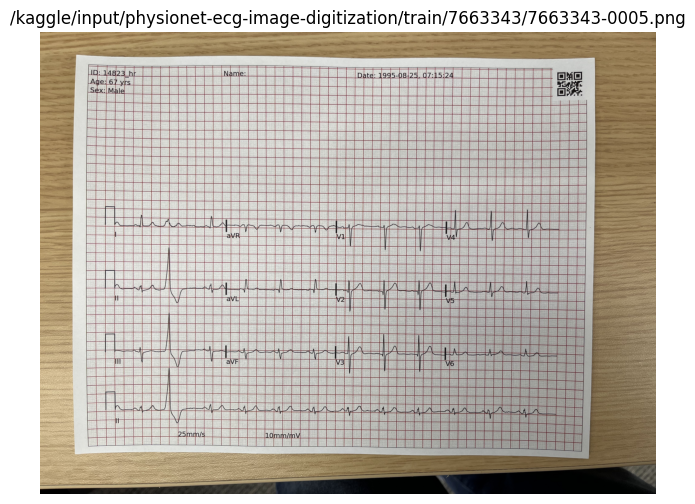

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# pick a random training example
import pandas as pd
train_df = pd.read_csv("/kaggle/input/physionet-ecg-image-digitization/train.csv")

example_id = train_df.iloc[0]["id"]
img_path = f"/kaggle/input/physionet-ecg-image-digitization/train/{example_id}/{example_id}-0005.png"

img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis("off")
plt.title(img_path)


# ============================================================
# 1) Utility: image reading
# ============================================================

In [3]:
def read_rgb(path: Path) -> Image.Image:
    # Robust PIL open
    with Image.open(path) as im:
        return im.convert("RGB")

# ============================================================
# 2) OPTIONAL: Simple 12-lead sheet cropper
#    If your training images are full ECG sheets (12 leads),
#    this attempts a naive 3x4 grid split.
#
#    If your training images are already single-lead, you can
#    bypass this and set "use_cropper=False".
# ============================================================

In [4]:
def crop_12lead_grid(img: Image.Image, lead: str) -> Image.Image:
    """
    Naive 3 columns x 4 rows grid crop.
    Works as a baseline if sheets are consistent.
    You should improve using template matching / vendor detection for higher scores.
    """
    w, h = img.size
    # Remove a little margin (titles/borders)
    mx = int(0.03 * w)
    my = int(0.06 * h)
    x0, y0, x1, y1 = mx, my, w - mx, h - my
    w2, h2 = x1 - x0, y1 - y0

    cols, rows = 3, 4
    cw = w2 / cols
    rh = h2 / rows

    # Standard ordering varies by vendor; this is a common layout guess.
    # Row-major mapping (top-left -> top-right, then next row).
    # You may need to change this mapping if your sheets differ.
    lead_to_idx = {
        "I": 0, "II": 1, "III": 2,
        "aVR": 3, "aVL": 4, "aVF": 5,
        "V1": 6, "V2": 7, "V3": 8,
        "V4": 9, "V5":10, "V6":11
    }
    idx = lead_to_idx[lead]
    r = idx // cols
    c = idx % cols

    left   = int(x0 + c * cw)
    upper  = int(y0 + r * rh)
    right  = int(x0 + (c + 1) * cw)
    lower  = int(y0 + (r + 1) * rh)

    return img.crop((left, upper, right, lower))

# ============================================================
# 3) Build training pairs
#    We try to find, for each base_id:
#      - a "good" training image (variant) and optionally crop per lead
#      - the ground-truth signal from train/[id]/[id].csv columns
#
#    The competition dataset contains multiple image variants per id:
#      train/[id]/[id]-0003.png, -0004.png, ...
#    We will sample variants to improve robustness.
# ============================================================

In [5]:
def list_train_variants(base_id: str):
    d = ROOT / "train" / base_id
    if not d.exists():
        return []
    # typical: {id}-0001.png ... etc
    return sorted(d.glob(f"{base_id}-*.png"))

def load_train_signal(base_id: str) -> pd.DataFrame:
    # train/[id]/[id].csv contains columns for 12 leads
    p = ROOT / "train" / base_id / f"{base_id}.csv"
    return pd.read_csv(p)


# ============================================================
# 4) Dataset (Implicit time sampling)
# ============================================================

In [6]:
@dataclass
class TrainConfig:
    image_size: int = 384
    points_per_item: int = 1024   # sampled timepoints per batch item
    use_cropper: bool = True      # set False if train images are already single-lead
    max_variants_per_id: int = 6  # cap variants to control epoch time
    augment: bool = True

class ECGImplicitTrainDataset(Dataset):
    """
    Returns:
      img_tensor: [3,H,W]
      t:         [K] normalized in [0,1]
      y:         [K] target values (mV) aligned with t
      lead_idx:  int (0..11) for optional embedding
    """
    def __init__(self, train_df: pd.DataFrame, cfg: TrainConfig):
        self.train_df = train_df.copy()
        self.cfg = cfg

        # Expand (base_id, lead, variant_path)
        samples = []
        for base_id in self.train_df["id"].astype(str).tolist():
            var_paths = list_train_variants(base_id)
            if len(var_paths) == 0:
                continue
            if cfg.max_variants_per_id and len(var_paths) > cfg.max_variants_per_id:
                # keep a diverse subset across artifact types
                # (uniformly sample across sorted list)
                idxs = np.linspace(0, len(var_paths)-1, cfg.max_variants_per_id).round().astype(int)
                var_paths = [var_paths[i] for i in idxs]

            samples.append((base_id, var_paths))

        self.base_ids = [s[0] for s in samples]
        self.variants = {bid: vps for bid, vps in samples}

        # cache signals (kept in RAM; ok for moderate sizes)
        self.signal_cache = {}

        # transforms
        self.base_tf = transforms.Compose([
            transforms.Resize((cfg.image_size, cfg.image_size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

        if cfg.augment:
            self.aug_tf = transforms.Compose([
                transforms.RandomApply([
                    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.1, hue=0.02)
                ], p=0.7),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2))
                ], p=0.3),
                transforms.RandomApply([
                    transforms.RandomRotation(degrees=2.0, expand=False)
                ], p=0.4),
            ])
        else:
            self.aug_tf = None

        self.lead_to_idx = {l:i for i,l in enumerate(LEADS)}

        # Flatten index: each __getitem__ chooses (base_id, lead) then variant
        self.index = []
        for base_id in self.base_ids:
            for lead in LEADS:
                self.index.append((base_id, lead))

    def __len__(self):
        return len(self.index)

    def _get_signal_df(self, base_id: str) -> pd.DataFrame:
        if base_id not in self.signal_cache:
            self.signal_cache[base_id] = load_train_signal(base_id)
        return self.signal_cache[base_id]

    def __getitem__(self, idx: int):
        base_id, lead = self.index[idx]
        lead_idx = self.lead_to_idx[lead]

        # choose a random variant to improve artifact robustness
        var_paths = self.variants[base_id]
        img_path = random.choice(var_paths)
        img = read_rgb(img_path)

        if self.cfg.use_cropper:
            img = crop_12lead_grid(img, lead)

        if self.aug_tf is not None:
            img = self.aug_tf(img)

        img_t = self.base_tf(img)  # [3,H,W]

        sig_df = self._get_signal_df(base_id)
        y_full = sig_df[lead].values.astype(np.float32)
        n = len(y_full)

        # Sample K time points (implicit)
        K = self.cfg.points_per_item
        # stratified-ish sampling for better coverage
        ids = np.random.randint(0, n, size=K)
        ids.sort()
        t = ids.astype(np.float32) / max(1, (n - 1))
        y = y_full[ids]

        return img_t, torch.from_numpy(t), torch.from_numpy(y), torch.tensor(lead_idx, dtype=torch.long)


# ============================================================
# 5) Test dataset
# ============================================================

In [7]:
class ECGTestDataset(Dataset):
    def __init__(self, test_df: pd.DataFrame, image_size=384):
        self.test_df = test_df.copy()
        self.image_size = image_size

        self.tf = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

        self.lead_to_idx = {l:i for i,l in enumerate(LEADS)}

    def __len__(self):
        return len(self.test_df)

    def __getitem__(self, idx):
        row = self.test_df.iloc[idx]
        img_path = ROOT / "test" / f"{row['id']}.png"
        img = read_rgb(img_path)
        img_t = self.tf(img)
        lead_idx = self.lead_to_idx[row["lead"]]
        nrows = int(row["number_of_rows"])
        base_id = row["id"]
        lead = row["lead"]
        fs = float(row["fs"])
        return base_id, lead, fs, nrows, img_t, torch.tensor(lead_idx, dtype=torch.long)


# ============================================================
# 6) Model: CNN encoder + implicit MLP decoder
# ============================================================

In [8]:
class FourierFeatures(nn.Module):
    """Positional encoding for t in [0,1]."""
    def __init__(self, num_bands=16, max_freq=64.0):
        super().__init__()
        self.num_bands = num_bands
        freqs = torch.linspace(1.0, max_freq, num_bands)
        self.register_buffer("freqs", freqs)

    def forward(self, t):  # t: [B,K] or [K]
        if t.dim() == 1:
            t = t[None, :]
        # [B,K,1] * [num_bands] -> [B,K,num_bands]
        angles = 2.0 * math.pi * t[..., None] * self.freqs[None, None, :]
        return torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # [B,K,2*num_bands]

class Encoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        # torchvision backbone (offline-available)
        backbone = torchvision.models.efficientnet_b0(weights=None)
        self.backbone = backbone.features  # conv features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, out_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        f = self.backbone(x)
        f = self.pool(f)
        z = self.proj(f)
        return z  # [B,out_dim]

class ImplicitDecoder(nn.Module):
    def __init__(self, latent_dim=512, lead_emb_dim=32, ff_bands=16, hidden=512, depth=4):
        super().__init__()
        self.lead_emb = nn.Embedding(len(LEADS), lead_emb_dim)
        self.ff = FourierFeatures(num_bands=ff_bands, max_freq=64.0)

        in_dim = latent_dim + lead_emb_dim + (2 * ff_bands)
        layers = []
        d = in_dim
        for _ in range(depth):
            layers += [nn.Linear(d, hidden), nn.SiLU(), nn.Dropout(0.05)]
            d = hidden
        layers += [nn.Linear(d, 1)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, z, t, lead_idx):
        """
        z: [B,latent]
        t: [B,K] in [0,1]
        lead_idx: [B] int
        returns y: [B,K]
        """
        B = z.size(0)
        if t.dim() == 1:
            t = t[None, :].repeat(B, 1)

        pe = self.ff(t)  # [B,K,2*ff]
        lead_e = self.lead_emb(lead_idx)[:, None, :].expand(-1, t.size(1), -1)  # [B,K,lead_emb]
        z_e = z[:, None, :].expand(-1, t.size(1), -1)  # [B,K,latent]
        x = torch.cat([z_e, lead_e, pe], dim=-1)  # [B,K,D]
        y = self.mlp(x).squeeze(-1)  # [B,K]
        return y

class ECGImplicitModel(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.enc = Encoder(out_dim=latent_dim)
        self.dec = ImplicitDecoder(latent_dim=latent_dim)

    def forward(self, img, t, lead_idx):
        z = self.enc(img)
        y = self.dec(z, t, lead_idx)
        return y

# ============================================================
# 7) Loss: robust regression + smoothness prior
# ============================================================

In [9]:
def smoothness_loss(t, y_pred):
    """
    Encourage local smoothness w.r.t time in sampled points.
    t: [B,K] sorted
    y_pred: [B,K]
    """
    dy = y_pred[:, 1:] - y_pred[:, :-1]
    dt = (t[:, 1:] - t[:, :-1]).clamp_min(1e-4)
    slope = dy / dt
    return (slope[:, 1:] - slope[:, :-1]).abs().mean()

# ============================================================
# 8) Train / Validate split
# ============================================================

In [10]:
def split_ids(train_df, val_frac=0.08, seed=42):
    ids = train_df["id"].astype(str).unique().tolist()
    rng = np.random.default_rng(seed)
    rng.shuffle(ids)
    n_val = max(1, int(len(ids) * val_frac))
    val_ids = set(ids[:n_val])
    tr_ids  = set(ids[n_val:])
    tr_df = train_df[train_df["id"].astype(str).isin(tr_ids)].reset_index(drop=True)
    va_df = train_df[train_df["id"].astype(str).isin(val_ids)].reset_index(drop=True)
    return tr_df, va_df

# ============================================================
# 9) Main training loop
# ============================================================

In [11]:
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    loss_meter = 0.0
    n = 0

    for img, t, y, lead_idx in loader:
        img = img.to(DEVICE, non_blocking=True)
        t = t.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        lead_idx = lead_idx.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # AMP disabled for debugging stability
        with torch.amp.autocast("cuda", enabled=False):
            yhat = model(img, t, lead_idx)

            # NaN / Inf guards on predictions
            if torch.isnan(yhat).any() or torch.isinf(yhat).any():
                print("NaN/Inf detected in yhat — skipping batch")
                optimizer.zero_grad(set_to_none=True)
                continue

            # NaN / Inf guards on targets
            if torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in targets — skipping batch")
                optimizer.zero_grad(set_to_none=True)
                continue

            loss = F.smooth_l1_loss(yhat, y)

            # Guard loss itself
            if torch.isnan(loss) or torch.isinf(loss):
                print("NaN/Inf detected in loss — skipping batch")
                optimizer.zero_grad(set_to_none=True)
                continue

        loss.backward()
        optimizer.step()

        loss_meter += loss.item() * img.size(0)
        n += img.size(0)

    if n == 0:
        return float("nan")

    return loss_meter / n


@torch.no_grad()
def validate(model, loader):
    model.eval()
    loss_meter = 0.0
    n = 0
    for img, t, y, lead_idx in loader:
        img = img.to(DEVICE, non_blocking=True)
        t = t.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        lead_idx = lead_idx.to(DEVICE, non_blocking=True)

        yhat = model(img, t, lead_idx)
        l1 = F.smooth_l1_loss(yhat, y)
        loss_meter += l1.item() * img.size(0)
        n += img.size(0)
    return loss_meter / max(1, n)


# ============================================================
# 10) Inference (chunked time queries)
# ============================================================

In [12]:
@torch.no_grad()
def predict_signal(model, img_t, lead_idx, nrows, chunk=2048):
    """
    img_t: [1,3,H,W]
    lead_idx: [1]
    returns: np.array [nrows]
    """
    model.eval()
    img_t = img_t.to(DEVICE)
    lead_idx = lead_idx.to(DEVICE)

    # Encode once
    z = model.enc(img_t)  # [1,latent]

    # time coordinates
    t = torch.linspace(0.0, 1.0, steps=nrows, device=DEVICE)[None, :]  # [1,nrows]

    out = []
    for start in range(0, nrows, chunk):
        end = min(nrows, start + chunk)
        t_chunk = t[:, start:end]  # [1,chunk]
        y_chunk = model.dec(z, t_chunk, lead_idx)  # [1,chunk]
        out.append(y_chunk.squeeze(0).float().cpu().numpy())

    return np.concatenate(out, axis=0)

# ============================================================
# 11) Run
# ============================================================

In [ ]:
# Load dataframes
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Basic sanity checks
assert "id" in train_df.columns
assert set(["id", "lead", "fs", "number_of_rows"]).issubset(set(test_df.columns))

# Split
tr_df, va_df = split_ids(train_df, val_frac=0.08, seed=42)

# Debug/stability-first config (T4-safe)
cfg = TrainConfig(
    image_size=384,
    points_per_item=512,
    use_cropper=True,        # confirmed correct: train images are full 12-lead sheets
    max_variants_per_id=3,
    augment=True
)

train_ds = ECGImplicitTrainDataset(tr_df, cfg)
val_ds   = ECGImplicitTrainDataset(va_df, cfg)

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

model = ECGImplicitModel(latent_dim=512).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)

# IMPORTANT: Disable AMP temporarily to debug NaNs reliably.
# Once stable (finite train/val), re-enable AMP for speed.
scaler = torch.amp.GradScaler("cuda", enabled=False)

best_val = float("inf")

EPOCHS = 1  # smoke test first; increase after NaNs are resolved

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    va_loss = validate(model, val_loader)

    print(f"Epoch {epoch:02d} | train {tr_loss:.5f} | val {va_loss:.5f}")

    # Only save if val_loss is a valid finite number
    if np.isfinite(va_loss) and (va_loss < best_val):
        best_val = va_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("  saved best_model.pt")

# Load best (guarded)
if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
else:
    print("WARNING: best_model.pt not found (training may have produced NaNs). Using current weights.")



NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf detected in targets — skipping batch
NaN/Inf de

# ============================================================
# 12) Create submission
# ============================================================

In [ ]:
# Load sample submission to ensure correct format/ids
if SAMPLE_SUB_PATH.exists():
    sample_sub = pd.read_parquet(SAMPLE_SUB_PATH)
else:
    # fallback if sample exists in dataset
    sample_sub = pd.read_parquet(ROOT / "sample_submission.parquet")

# Build a quick map from test_df rows to allow generating the composite ids
# The sample submission uses ids like {base_id}_{row_id}_{lead}
# where base_id is test_df.id and lead is test_df.lead
# We will generate all predicted rows per (base_id, lead) and then merge to sample order.

test_ds = ECGTestDataset(test_df, image_size=cfg.image_size)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

pred_records = []
for base_id, lead, fs, nrows, img_t, lead_idx in test_loader:
    base_id = base_id[0]
    lead = lead[0]
    nrows = int(nrows.item())
    # lead_idx: shape [1]
    yhat = predict_signal(model, img_t, lead_idx, nrows, chunk=2048)  # [nrows]

    # Create ids matching expected format: {base_id}_{row_id}_{lead}
    # row_id is 0..nrows-1
    for i in range(nrows):
        pred_records.append((f"{base_id}_{i}_{lead}", float(yhat[i])))

# Pred DF
pred_df = pd.DataFrame(pred_records, columns=["id", "value"])

# Align to sample submission ids (guarantees correct rows/order)
sub = sample_sub[["id"]].merge(pred_df, on="id", how="left")

# If any missing (should not), fill with 0.0
sub["value"] = sub["value"].fillna(0.0).astype(np.float32)

# Save as required name (csv or parquet)
sub_path = "submission.parquet"
sub.to_parquet(sub_path, index=False)

print("Saved:", sub_path, "rows:", len(sub))

# Free memory
gc.collect()
torch.cuda.empty_cache()